In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
import scipy.sparse as sparse
from sklearn.decomposition import NMF, TruncatedSVD
import pymysql
import json
import datetime as dt
from datetime import datetime, timezone, timedelta
import time
from pytz import timezone
from dateutil import parser
import re
from tqdm import tqdm_notebook
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import re
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

In [2]:
answer_scores = pd.read_csv('input/answer_scores.csv')
answers = pd.read_csv('input/answers.csv')
comments = pd.read_csv('input/comments.csv')
emails = pd.read_csv('input/emails.csv')
group_memberships = pd.read_csv('input/group_memberships.csv')
groups = pd.read_csv('input/groups.csv')
matches = pd.read_csv('input/matches.csv')
professionals = pd.read_csv('input/professionals.csv')
question_scores = pd.read_csv('input/question_scores.csv')
questions = pd.read_csv('input/questions.csv')
school_memberships = pd.read_csv('input/school_memberships.csv')
students = pd.read_csv('input/students.csv')
tag_questions = pd.read_csv('input/tag_questions.csv')
tag_users = pd.read_csv('input/tag_users.csv')
tags = pd.read_csv('input/tags.csv')

In [3]:
students.describe(include='all')

,students_id,students_location,students_date_joined
count,30971,28938,30971
unique,30971,5480,29736
top,19a931cf1a0e47f99566d64c4f108583,"New York, New York",2013-11-22 05:00:00 UTC+0000
freq,1,1313,246


Text(0.5,1,'students location top 30')

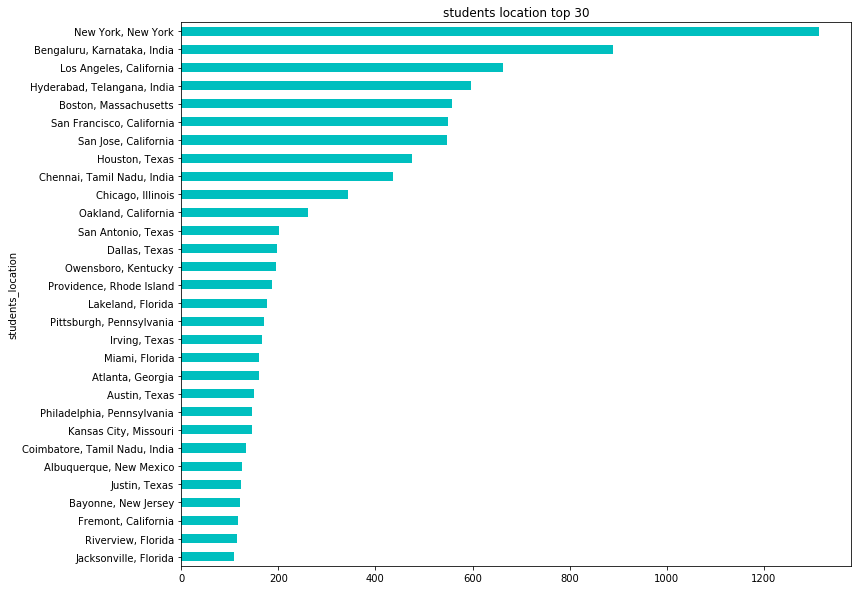

In [4]:
students.groupby('students_location').count().sort_values('students_id',ascending=True)\
                     ['students_id'].tail(30).plot.barh(color='c',figsize=(12, 10))
plt.title('students location top 30')

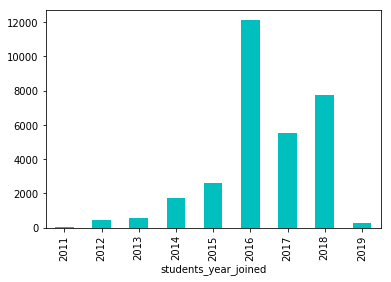

In [5]:
students['students_year_joined']=students['students_date_joined'].str[:4]
students.groupby('students_year_joined').count()['students_id'].plot.bar(color='c')
students=students.drop('students_year_joined', axis=1)

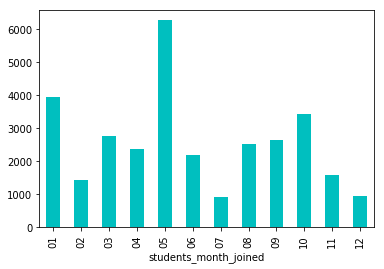

In [6]:
students['students_month_joined']=students['students_date_joined'].str[5:7]
students.groupby('students_month_joined').count()['students_id'].plot.bar(color='c')
students=students.drop('students_month_joined', axis=1)

In [7]:
professionals.describe(include='all')

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
count,28152,25054,25576,26085,28152
unique,28152,2582,2470,22272,28000
top,2c96e5155f784ca28bf7445109c9860c,"New York, New York",Telecommunications,--,2011-12-26 05:00:00 UTC+0000
freq,1,1337,3166,325,45


Text(0.5,1,'professionals location top 30')

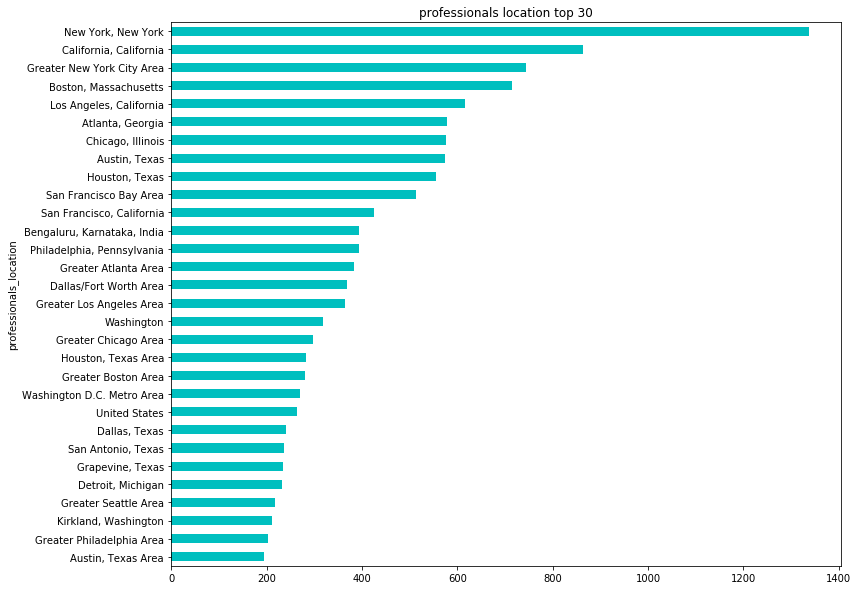

In [8]:
professionals.groupby('professionals_location').count().sort_values('professionals_id',ascending=True)\
             ['professionals_id'].tail(30).plot.barh(color='c', figsize=(12, 10))
plt.title('professionals location top 30')

Text(0.5,1,'professionals industry top 30')

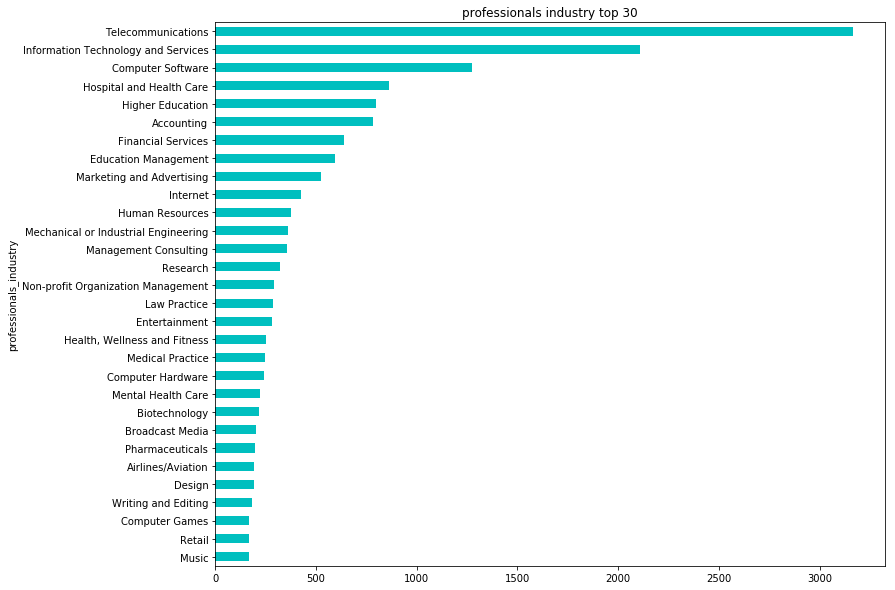

In [9]:
professionals.groupby('professionals_industry').count().sort_values('professionals_id',ascending=True)\
                 ['professionals_id'].tail(30).plot.barh(color='c', figsize=(12, 10))
plt.title('professionals industry top 30')

Text(0.5,1,'professionals headline top 30')

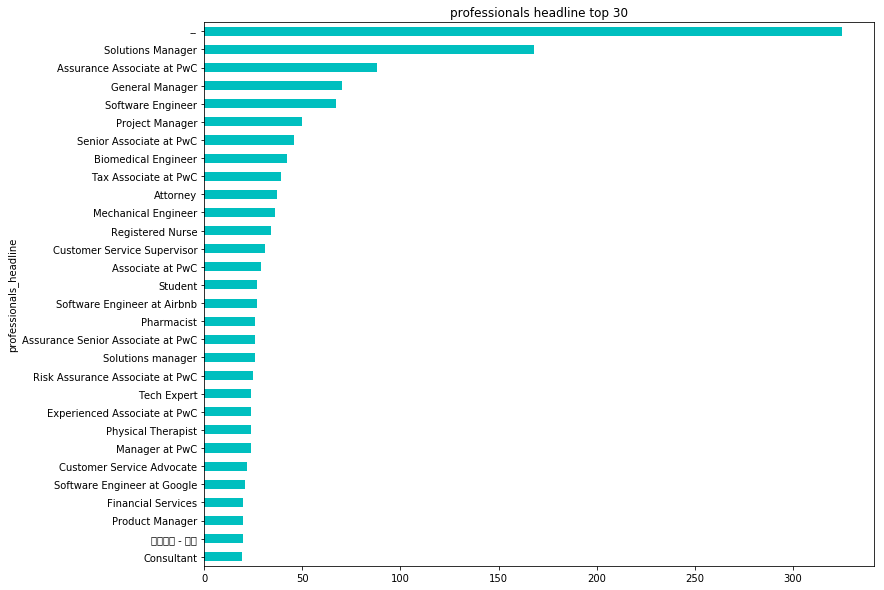

In [10]:
professionals.groupby('professionals_headline').count().sort_values('professionals_id',ascending=True)\
              ['professionals_id'].tail(30).plot.barh(color='c',figsize=(12, 10))
plt.title('professionals headline top 30')

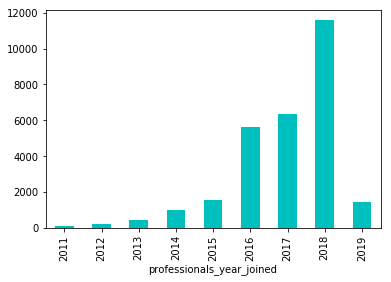

In [11]:
professionals['professionals_year_joined']=professionals['professionals_date_joined'].str[:4]
professionals.groupby('professionals_year_joined').count()['professionals_id'].plot.bar(color='c')
professionals=professionals.drop('professionals_year_joined', axis=1)

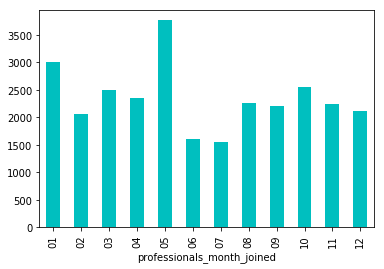

In [12]:
professionals['professionals_month_joined']=professionals['professionals_date_joined'].str[5:7]
professionals.groupby('professionals_month_joined').count()['professionals_id'].plot.bar(color='c')
professionals=professionals.drop('professionals_month_joined', axis=1)

In [13]:
questions.describe(include='all')

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
count,23931,23931,23931,23931,23931
unique,23931,12329,23869,23739,23681
top,7eac13bd0c1a46b0b7c9361f5df89519,2fe767de78fa4dfd83f0021cf7712064,2018-04-16 16:52:39 UTC+0000,How do I become an IAS officer?,Accounting student at Towson university #acco...
freq,1,93,2,6,16


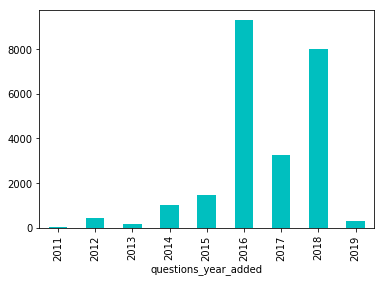

In [14]:
questions['questions_year_added']=questions['questions_date_added'].str[:4]
questions.groupby('questions_year_added').count()['questions_id'].plot.bar(color='c')
questions=questions.drop('questions_year_added', axis=1)

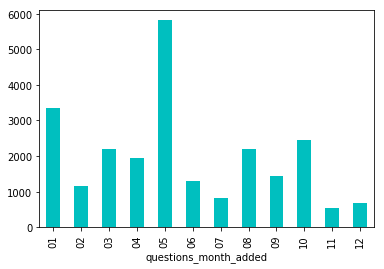

In [15]:
questions['questions_month_added']=questions['questions_date_added'].str[5:7]
questions.groupby('questions_month_added').count()['questions_id'].plot.bar(color='c')
questions=questions.drop('questions_month_added', axis=1)

Text(0.5,1,'Number_of_question   frequency per student')

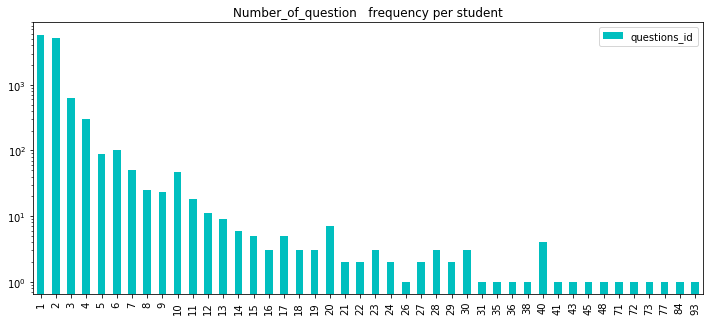

In [16]:
pd.DataFrame(questions.groupby('questions_author_id').count()['questions_id']\
             .value_counts()).sort_index().plot.bar(logy=True, color='c', figsize=(12, 5))
plt.title('Number_of_question   frequency per student')

Text(0,0.5,'frequency')

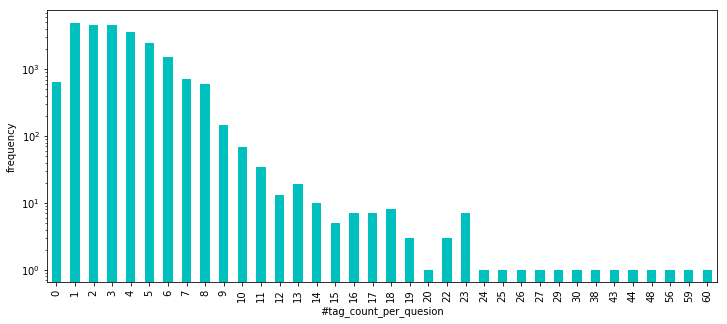

In [17]:
questions['#tag_count_per_quesion']=questions['questions_body'].apply(lambda x: len(re.findall('#',x)))
questions.groupby('#tag_count_per_quesion').count()['questions_id'].plot.bar(logy=True, color='c', figsize=(12, 5))
questions=questions.drop('#tag_count_per_quesion', axis=1)
plt.ylabel('frequency')

In [3]:
question_scores.describe(include='all')

,id,score
count,23928,23928.000000
unique,23928,NaN
top,6e438b51820a43b881dd90b6b1188498,NaN
freq,1,NaN
mean,NaN,2.900326
std,NaN,4.745618
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,2.000000
75%,NaN,3.000000


Text(0.5,1,'Number_of_question_scores')

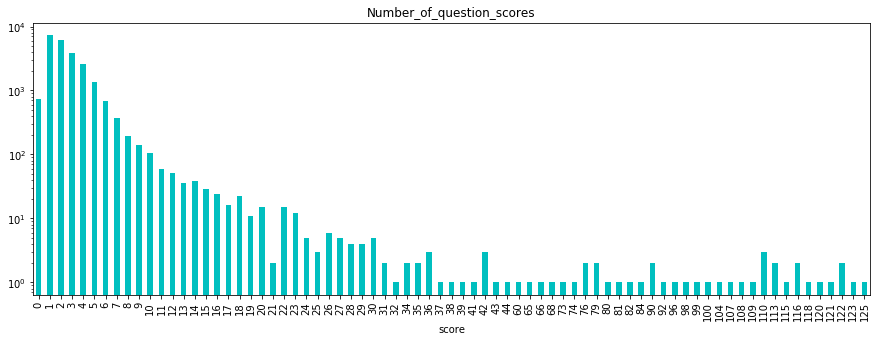

In [24]:
question_scores.groupby('score').count()['id'].plot.bar(logy=True, color='c', figsize=(15, 5))
plt.title('Number_of_question_scores')

In [18]:
answers.describe(include='all')

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
count,51123,51123,51123,51123,51122
unique,51123,10169,23110,51062,50401
top,d49720aae3d9476c864378c2aeaafd66,36ff3b3666df400f956f8335cf53e09e,8eb6ba7af57846acbfec5633e537192a,2017-05-10 19:02:08 UTC+0000,"<p>&lt;span style=""background-color: transpare..."
freq,1,1710,58,2,103


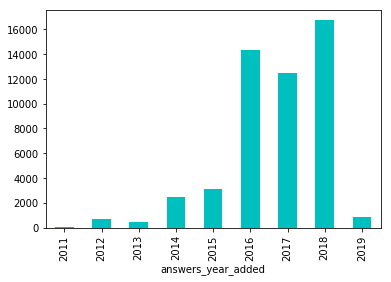

In [19]:
answers['answers_year_added']=answers['answers_date_added'].str[:4]
answers.groupby('answers_year_added').count()['answers_id'].plot.bar(color='c')
answers=answers.drop('answers_year_added', axis=1)

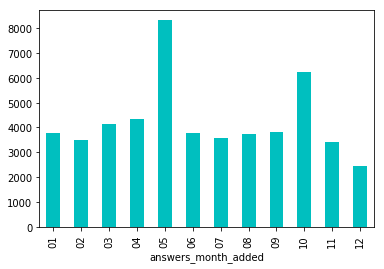

In [20]:
answers['answers_month_added']=answers['answers_date_added'].str[5:7]
answers.groupby('answers_month_added').count()['answers_id'].plot.bar(color='c')
answers=answers.drop('answers_month_added', axis=1)

Text(0,0.5,'frequency[LOG]')

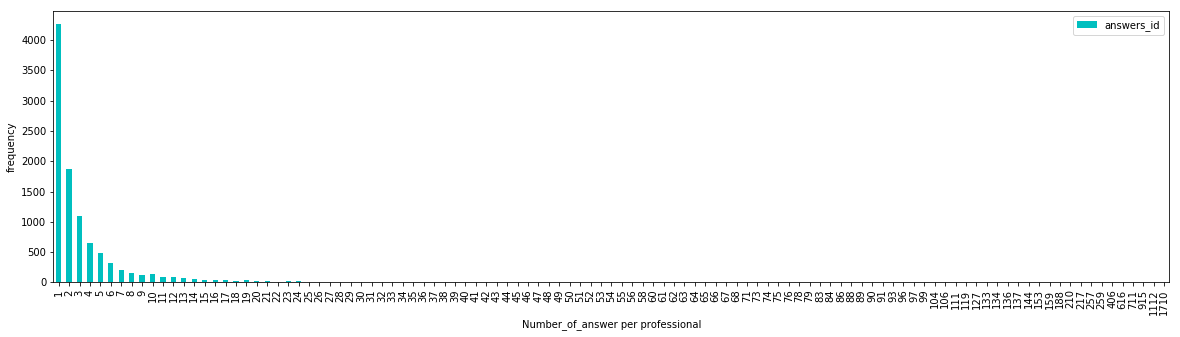

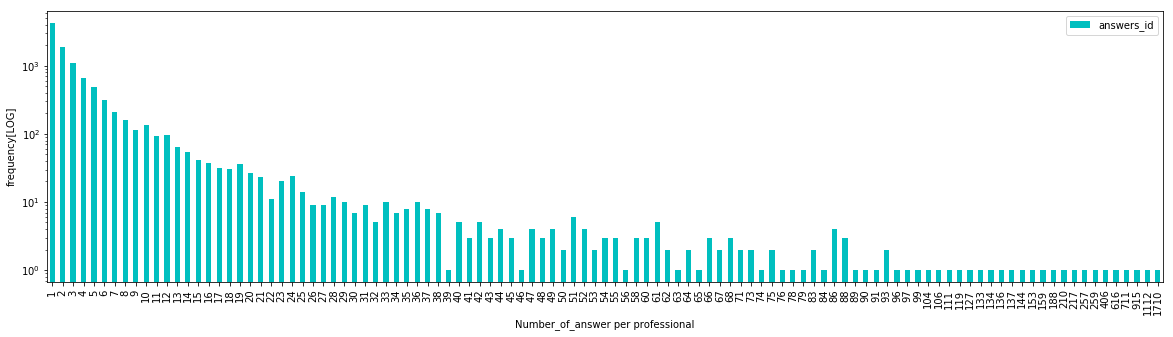

In [21]:
pd.DataFrame(answers.groupby('answers_author_id').count()['answers_id']\
             .value_counts()).sort_index().plot.bar(logy=False, color='c', figsize=(20, 5))
plt.xlabel('Number_of_answer per professional')
plt.ylabel('frequency')
pd.DataFrame(answers.groupby('answers_author_id').count()['answers_id']\
             .value_counts()).sort_index().plot.bar(logy=True, color='c', figsize=(20, 5))
plt.xlabel('Number_of_answer per professional')
plt.ylabel('frequency[LOG]')

In [33]:
def delta_days(date1, date2):
    d1=dt.datetime.strptime(date1[:19], '%Y-%m-%d %H:%M:%S')
    d2=dt.datetime.strptime(date2[:19], '%Y-%m-%d %H:%M:%S')
    return (d1-d2).days+(d1-d2).seconds/(3600*24)

In [34]:
for i in tqdm_notebook(answers.index):
    answers.loc[i,'Response_day']=delta_days(answers.loc[i,'answers_date_added'],
        questions[questions['questions_id']==answers.loc[i,'answers_question_id']].iloc[0]['questions_date_added'])

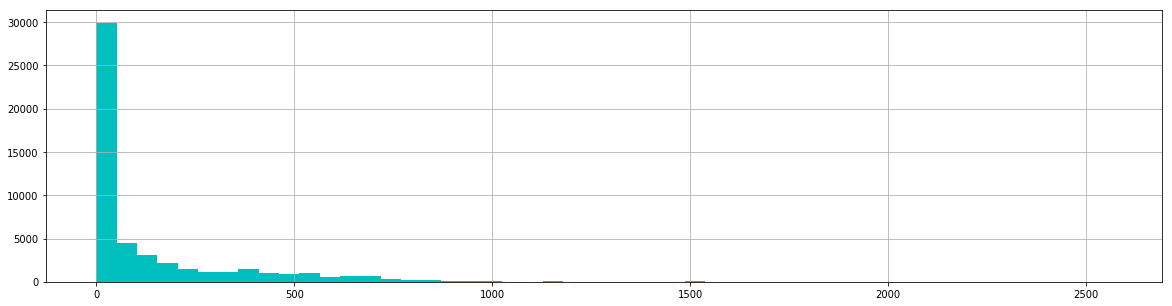

In [35]:
answers['Response_day'].hist(bins=50, color='c', figsize=(20, 5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020EBB7BDD68>]],
      dtype=object)

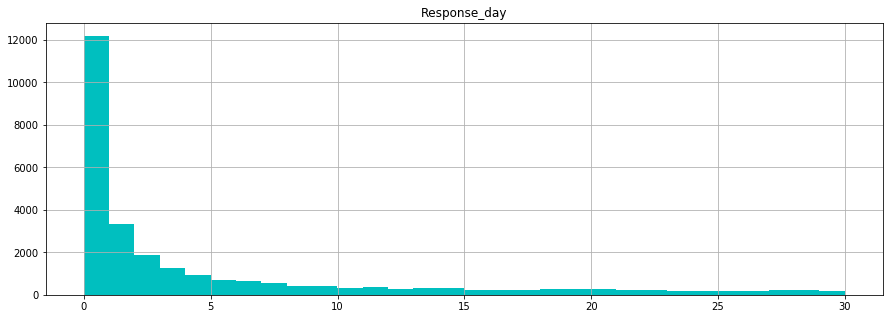

In [36]:
answers[(answers['Response_day']<30)].hist(bins=30, color='c', figsize=(15, 5))

In [6]:
answer_scores.describe(include='all')

,id,score
count,51138,51138.000000
unique,51138,NaN
top,eb047fa53550419397820c7bb8c0393a,NaN
freq,1,NaN
mean,NaN,0.415816
std,NaN,0.921717
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


Text(0.5,1,'Number_of_answer_scores')

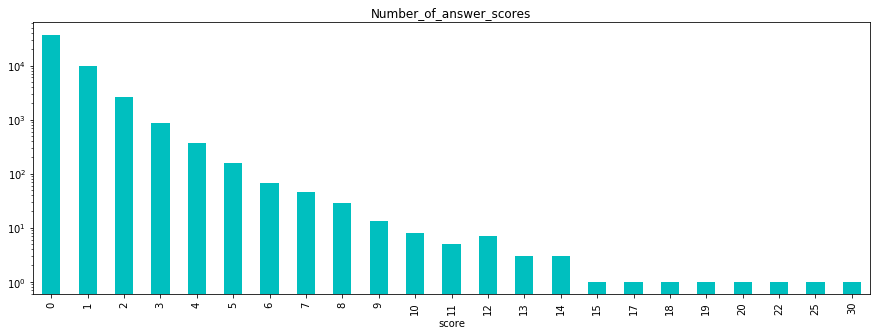

In [27]:
answer_scores.groupby('score').count()['id'].plot.bar(logy=True, color='c', figsize=(15, 5))
plt.title('Number_of_answer_scores')

In [37]:
comments.describe(include='all')

,comments_id,comments_author_id,comments_parent_content_id,comments_date_added,comments_body
count,14966,14966,14966,14966,14962
unique,14966,4231,9923,14905,11963
top,ff68ca9421ac431c93c85d9adc7386ac,36ff3b3666df400f956f8335cf53e09e,4c6ae4bd2136472899c15b798eb9d3df,2016-07-22 22:13:05 UTC+0000,Thank you!
freq,1,317,30,3,388


Text(0,0.5,'frequency[LOG]')

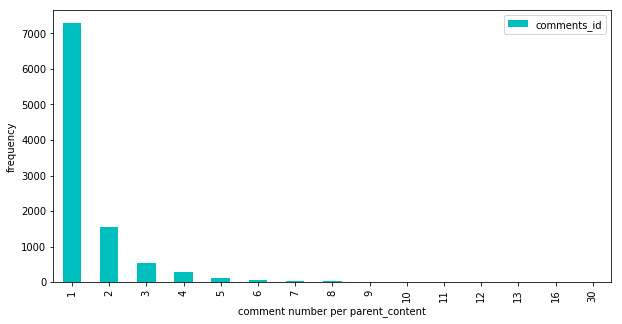

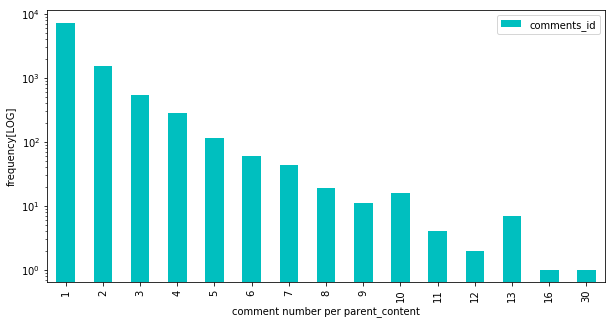

In [38]:
pd.DataFrame(comments.groupby('comments_parent_content_id').count()['comments_id']\
             .value_counts()).sort_index().plot.bar(logy=False, color='c', figsize=(10, 5))
plt.xlabel('comment number per parent_content')
plt.ylabel('frequency')
pd.DataFrame(comments.groupby('comments_parent_content_id').count()['comments_id']\
             .value_counts()).sort_index().plot.bar(logy=True, color='c', figsize=(10, 5))
plt.xlabel('comment number per parent_content')
plt.ylabel('frequency[LOG]')

In [39]:
comments.groupby('comments_parent_content_id').count()['comments_id'].shape[0]

9923

In [40]:
comments.groupby('comments_parent_content_id').count()['comments_id'].index[:].isin(answers['answers_id']).sum()

8048

In [41]:
comments.groupby('comments_parent_content_id').count()['comments_id'].index[:].isin(questions['questions_id']).sum()

1875

Text(0.5,1,'parent content of comments')

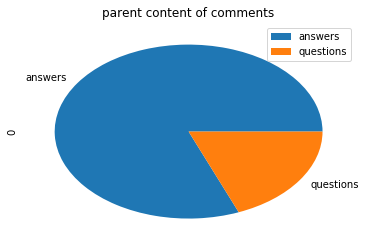

In [42]:
parent_content=pd.DataFrame(index=(['answers', 'questions']), data=([8048, 1875]))
parent_content.plot( kind='pie', subplots=True)
plt.title("parent content of comments")

In [43]:
comments['comments_body'].str.contains('Thank|thank|thk').sum()

8603

In [47]:
emails.describe(include='all')

,emails_id,emails_recipient_id,emails_date_sent,emails_frequency_level
count,1.850101e+06,1850101,1850101,1850101
unique,NaN,22168,1610163,3
top,NaN,0079e89bf1544926b98310e81315b9f1,2018-07-09 00:01:07 UTC+0000,email_notification_daily
freq,NaN,3496,33,1488240
mean,1.362206e+06,NaN,NaN,NaN
std,6.449917e+05,NaN,NaN,NaN
min,1.060000e+02,NaN,NaN,NaN
25%,8.813900e+05,NaN,NaN,NaN
50%,1.400010e+06,NaN,NaN,NaN
75%,1.911846e+06,NaN,NaN,NaN


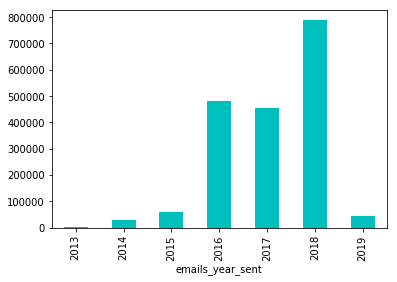

In [48]:
emails['emails_year_sent']=emails['emails_date_sent'].str[:4]
emails.groupby('emails_year_sent').count()['emails_id'].plot.bar(color='c')
emails=emails.drop('emails_year_sent', axis=1)

In [49]:
emails.groupby('emails_recipient_id').count()['emails_id'].index[:].isin(students['students_id']).sum()

0

In [50]:
emails.groupby('emails_recipient_id').count()['emails_id'].index[:].isin(professionals['professionals_id']).sum()

22168

Text(0.5,1,'emails_frequency_level')

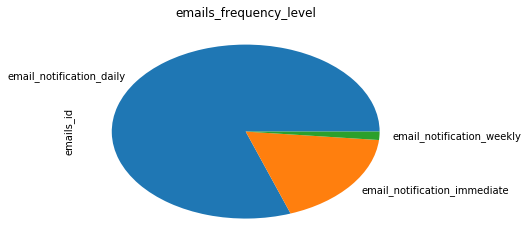

In [51]:
emails.groupby('emails_frequency_level').count()['emails_id'].plot( kind='pie', subplots=True)
plt.title("emails_frequency_level")

In [52]:
matches.describe(include='all')

,matches_email_id,matches_question_id
count,4.316275e+06,4316275
unique,NaN,21894
top,NaN,d9b06cd477a943b9b3821f37d64a1da3
freq,NaN,2099
mean,1.478192e+06,NaN
std,5.895280e+05,NaN
min,1.060000e+02,NaN
25%,1.011924e+06,NaN
50%,1.544656e+06,NaN
75%,1.970642e+06,NaN


In [53]:
matches.groupby('matches_question_id').count()['matches_email_id'].index[:].isin(questions['questions_id']).sum()

21894

Text(0.5,1,'Number_of_email   frequency per question')

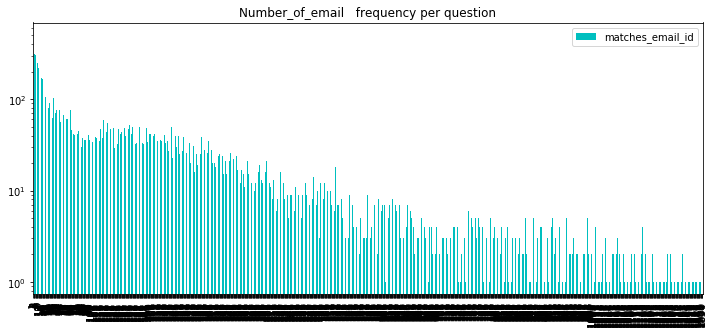

In [54]:
pd.DataFrame(matches.groupby('matches_question_id').count()['matches_email_id']\
             .value_counts()).sort_index().plot.bar(logy=True, color='c', figsize=(12, 5))
plt.title('Number_of_email   frequency per question')

In [55]:
len(matches['matches_email_id'].unique()), len(matches['matches_question_id'].unique())

(1794085, 21894)

In [56]:
tags.describe(include='all')

,tags_tag_id,tags_tag_name
count,16269.000000,16268
unique,NaN,16268
top,NaN,#agriculture
freq,NaN,1
mean,28511.686336,NaN
std,8421.414012,NaN
min,27.000000,NaN
25%,21711.000000,NaN
50%,31101.000000,NaN
75%,35207.000000,NaN


In [57]:
tags.head()

,tags_tag_id,tags_tag_name
0,27490,college
1,461,computer-science
2,593,computer-software
3,27292,business
4,18217,doctor


In [58]:
industries = set(professionals['professionals_industry'].dropna())
tag_name = set(tags['tags_tag_name'].dropna())

In [59]:
industries_in_tags = [i for i in industries if i.lower() in tag_name]

In [60]:
type(tag_name)

set

In [50]:
len(industries_in_tags)

343